In [1]:
import pandas as pd
import os
import collections
import csv
import logging
import numpy as np
import datetime as datetime
import types
import pickle

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from top2vec import Top2Vec

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
!which jupyter

/home/ubuntu/thesis_env2/bin/jupyter


In [3]:
df = pd.read_pickle('./data/df_processed_bigrams.pickle')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365200 entries, 0 to 369046
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   author             181507 non-null  object        
 1   date               365200 non-null  datetime64[ns]
 2   domain             365200 non-null  object        
 3   title              365115 non-null  object        
 4   url                365200 non-null  object        
 5   content            365200 non-null  object        
 6   topic_area         365200 non-null  object        
 7   content_processed  365200 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 25.1+ MB


In [5]:
df.head(1).append(df.tail(1))

,author,date,domain,title,url,content,topic_area,content_processed
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...
369046,NaN,2020-12-31,marketscreener,FTSE 100 wraps up worst year since 2008 financ...,https://www.marketscreener.com/quote/index/FTS...,"The FTSE 100 lost 1.5%, with consumer stocks, ...",business,ftse lost consumer stocks mainly unilever diag...


In [6]:
# Note to do - need to add time element

def log_newline(self, how_many_lines=1):
    file_handler = None
    if self.handlers:
        file_handler = self.handlers[0]

    # Switch formatter, output a blank line
    file_handler.setFormatter(self.blank_formatter)
    for i in range(how_many_lines):
        self.info('')

    # Switch back
    file_handler.setFormatter(self.default_formatter)

def logger_w2v():
    
    log_file = os.path.join('./data', 'word2vec.log')
    print('log file location: ', log_file)
    
    log_format= '%(asctime)s - %(levelname)s - [%(module)s]\t%(message)s'
    formatter = logging.Formatter(fmt=(log_format))
    
    fhandler = logging.FileHandler(log_file)
    fhandler.setFormatter(formatter)
    
    logger = logging.getLogger('word2vec')
    logger.setLevel(logging.DEBUG)
    logger.addHandler(fhandler)
    logger.default_formatter = formatter
    logger.blank_formatter = logging.Formatter(fmt="")
    logger.newline = types.MethodType(log_newline, logger)
    
    return logger
    

In [7]:
def tokenise_dataset(df):

    tokens = df['content_processed'].str.split(" ")

    return tokens

# Top2Vec

In [8]:
find_topics = False
min_count = 1000 # ignore words with total frequency less than this
speed = 'deep-learn' # can try 'deep-learn' for possible better embeddings but will take longer
# started deep-lear at 8pm, still going at 2pm the next day

if find_topics:
    # import lemmatised data
    with open('data/data_lemmatized.pickle', 'rb') as f:
        data_lemmatized = pickle.load(f)
    
    data_lemmatized_str = [' '.join(article) for article in data_lemmatized]
    print(len(data_lemmatized))
    print(len(data_lemmatized_str))
    
    # Find topics
    # ~ 12.5 hours to run on lemmatised data
    #documents = df['content_processed'][:50000].values
    documents = data_lemmatized_str
    model = Top2Vec(documents, workers=4, min_count=min_count, speed=speed)
    model.save('top2vec_vocab_limit_deep.model')
else:
    #model = Top2Vec.load('top2vec.model')
    model = Top2Vec.load('top2vec_vocab_limit.model')

print(len(model.topic_words))
print(model._get_word_vectors().shape)

1773
(9453, 300)


In [9]:
print(model.topic_words[0], '\n')
#print(model.topic_words[1], '\n')
#print(model.topic_words[2], '\n')

['barrels_day' 'bpd' 'crude' 'opec' 'glut' 'oil' 'barrel' 'refiner'
 'brent_crude' 'wti' 'eia' 'brent' 'crude_future' 'gasoline' 'shale'
 'crude_oil' 'refinery' 'output' 'libya' 'exxon' 'aramco' 'refining'
 'permian' 'producer' 'chevron' 'petroleum' 'saudi' 'reuters_poll'
 'importer' 'oil_ga' 'upstream' 'rig' 'hydrocarbon' 'rout' 'taper'
 'natural_ga' 'gulf' 'petrochemical' 'oilfield' 'refine' 'oil_gas'
 'curtailment' 'iraq' 'royal_dutch' 'diesel' 'chesapeake' 'lowest_level'
 'gallon' 'gregorio' 'slash'] 



### Get topic sizes

Number of documents most similar to each topic. Topics are in decreasing order of size.  
topic_sizes: The number of documents most similar to each topic.  
topic_nums: The unique index of every topic will be returned.  

In [10]:
topic_sizes, topic_ids = model.get_topic_sizes()
df_topic_sizes = pd.DataFrame(data=zip(topic_ids, topic_sizes), columns=['topic_id', 'num_docs'])

In [11]:
print(df_topic_sizes['num_docs'].sum())
df_topic_sizes

365200


,topic_id,num_docs
0,0,3882
1,1,2972
2,2,2739
3,3,2512
4,4,2155
...,...,...
1768,1768,19
1769,1769,19
1770,1770,18
1771,1771,18


<AxesSubplot:>

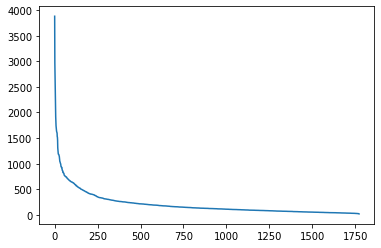

In [12]:
df_topic_sizes['num_docs'].plot()

### Get Topics
topic_words: For each topic the top 50 words are returned, in order of semantic similarity to topic.  
word_scores: For each topic the cosine similarity scores of the top 50 words to the topic are returned.  
topic_nums: The unique index of every topic will be returned.  

In [13]:
topic_words, word_scores, topic_ids = model.get_topics(model.get_num_topics())
topic_sizes, topic_ids = model.get_topic_sizes()
df_topics = pd.DataFrame(data=zip(topic_ids, topic_sizes, topic_words, word_scores), columns=['topic_id', 'topic_sizes', 'topic_words', 'word_scores'])

# add doc id's
df_topics['doc_ids'] = ''
for topic_idx, topic_size in enumerate(df_topics['topic_sizes']):
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_idx, num_docs=topic_size)
    df_idx = df.iloc[document_ids].index.values
    df_topics['doc_ids'].at[topic_idx] = df_idx
print(df_topics['topic_sizes'].sum())

#df_topics.to_pickle("df_topics_top2vec_vocab_limit.pickle")

365200


In [14]:
df_topics

,topic_id,topic_sizes,topic_words,word_scores,doc_ids
0,0,3882,"[barrels_day, bpd, crude, opec, glut, oil, bar...","[0.7554733, 0.7397255, 0.7277012, 0.7076352, 0...","[48334, 48284, 294425, 159978, 20322, 292171, ..."
1,1,2972,"[touching_face, hands_clean, sick, rate_dippe,...","[0.31247112, 0.20629022, 0.20435627, 0.2030590...","[676, 30063, 20903, 18668, 21959, 21573, 3624,..."
2,2,2739,"[nongaap, gaap, ebitdare, divestiture, teekay,...","[0.26054233, 0.23778984, 0.22579505, 0.1927944...","[334982, 239075, 91056, 85241, 100487, 8321, 1..."
3,3,2512,"[vaccine, pfizer_biontech, pfizerbiontech, pfi...","[0.80440575, 0.7686322, 0.7623384, 0.7583906, ...","[236636, 225984, 225378, 225321, 347974, 22533..."
4,4,2155,"[hedge_fund, insider_monkey, hedgie, similarly...","[0.7718193, 0.57161814, 0.5356776, 0.51193756,...","[133035, 171698, 133512, 169086, 133335, 17170..."
...,...,...,...,...,...
1768,1768,19,"[safehaven, crude_future, greenback, japanese_...","[0.55273753, 0.49876994, 0.49868113, 0.4946041...","[183052, 183053, 182081, 181526, 181789, 18255..."
1769,1769,19,"[strategist, choppy, treasury_yield, selloff, ...","[0.44933143, 0.42233846, 0.41821185, 0.3859547...","[250960, 250028, 252600, 250770, 253406, 24993..."
1770,1770,18,"[gift, card, debit, wallet, credit_card, press...","[0.5080503, 0.49814865, 0.40992847, 0.384071, ...","[314138, 313298, 314772, 313117, 314512, 31364..."
1771,1771,18,"[dare, commercialize, nda, bioscience, investi...","[0.50853056, 0.4186489, 0.3713347, 0.3697553, ...","[158636, 159688, 154610, 155910, 316975, 31669..."


### Search for topics than contain keywords
topic_words: For each topic the top 50 words are returned, in order of semantic similarity to topic.  
word_scores: For each topic the cosine similarity scores of the top 50 words to the topic are returned.  
topic_scores: For each topic the cosine similarity to the search keywords will be returned.  
topic_nums: The unique index of every topic will be returned.  

In [15]:
keywords = ["supply_chain"]
#keywords = ["digital_transformation"]
topic_words, word_scores, topic_scores, topic_ids = model.search_topics(keywords=keywords, num_topics=5)
df_topic_kw = pd.DataFrame(data=zip(topic_ids, topic_words, word_scores, topic_scores), columns=['topic_id', 'topic_words', 'word_scores', 'topic_scores'])

In [16]:
df_topic_kw

,topic_id,topic_words,word_scores,topic_scores
0,859,"[generic, pharmaceutical, drug, novartis, phar...","[0.5529777, 0.41644132, 0.4071582, 0.37119797,...",0.332119
1,914,"[garment, bangladesh, boohoo, clothing, clothe...","[0.7322744, 0.50282276, 0.46981946, 0.46685526...",0.287537
2,93,"[tools_checklist, reinvent, transformation, ag...","[0.5508231, 0.49446157, 0.48091435, 0.477627, ...",0.252878
3,825,"[wto, multilateral, directorgeneral, bilateral...","[0.78679776, 0.5122057, 0.4868957, 0.46711993,...",0.246379
4,1132,"[respirator, fema, surgical_mask, protective_g...","[0.5727843, 0.45496583, 0.4493539, 0.43521297,...",0.242761


In [17]:
df_topic_kw['topic_words'][1]

array(['garment', 'bangladesh', 'boohoo', 'clothing', 'clothe', 'apparel',
       'textile', 'fashion', 'factory', 'cambodia', 'migrant_worker',
       'cotton', 'myanmar', 'bof', 'footwear', 'adida', 'designer',
       'gucci', 'levi', 'leather', 'burberry', 'exporter', 'supply_chain',
       'nepal', 'shoe', 'tshirt', 'retailer', 'minimum_wage', 'malaysian',
       'malaysia', 'gown', 'ngo', 'nike', 'exploitation', 'jc_penney',
       'casual', 'wage', 'jacket', 'vietnam', 'dress', 'fabric',
       'store_closure', 'informal', 'ethiopia', 'livelihood', 'worker',
       'precarious', 'remittance', 'leicester', 'shirt'], dtype='<U15')

### Search articles by topic

After finding the relevant topic number can then search by this  
documents: The documents in a list, the most similar are first.  
doc_scores: Semantic similarity of document to topic. The cosine similarity of the document and topic vector.  
doc_ids: Unique ids of documents. If ids were not given, the index of document in the original corpus.  

In [18]:
df_topics

,topic_id,topic_sizes,topic_words,word_scores,doc_ids
0,0,3882,"[barrels_day, bpd, crude, opec, glut, oil, bar...","[0.7554733, 0.7397255, 0.7277012, 0.7076352, 0...","[48334, 48284, 294425, 159978, 20322, 292171, ..."
1,1,2972,"[touching_face, hands_clean, sick, rate_dippe,...","[0.31247112, 0.20629022, 0.20435627, 0.2030590...","[676, 30063, 20903, 18668, 21959, 21573, 3624,..."
2,2,2739,"[nongaap, gaap, ebitdare, divestiture, teekay,...","[0.26054233, 0.23778984, 0.22579505, 0.1927944...","[334982, 239075, 91056, 85241, 100487, 8321, 1..."
3,3,2512,"[vaccine, pfizer_biontech, pfizerbiontech, pfi...","[0.80440575, 0.7686322, 0.7623384, 0.7583906, ...","[236636, 225984, 225378, 225321, 347974, 22533..."
4,4,2155,"[hedge_fund, insider_monkey, hedgie, similarly...","[0.7718193, 0.57161814, 0.5356776, 0.51193756,...","[133035, 171698, 133512, 169086, 133335, 17170..."
...,...,...,...,...,...
1768,1768,19,"[safehaven, crude_future, greenback, japanese_...","[0.55273753, 0.49876994, 0.49868113, 0.4946041...","[183052, 183053, 182081, 181526, 181789, 18255..."
1769,1769,19,"[strategist, choppy, treasury_yield, selloff, ...","[0.44933143, 0.42233846, 0.41821185, 0.3859547...","[250960, 250028, 252600, 250770, 253406, 24993..."
1770,1770,18,"[gift, card, debit, wallet, credit_card, press...","[0.5080503, 0.49814865, 0.40992847, 0.384071, ...","[314138, 313298, 314772, 313117, 314512, 31364..."
1771,1771,18,"[dare, commercialize, nda, bioscience, investi...","[0.50853056, 0.4186489, 0.3713347, 0.3697553, ...","[158636, 159688, 154610, 155910, 316975, 31669..."


In [19]:
# Get all document scores - note: doc index is iloc
doc_id_score = []
for topic_num in df_topics['topic_id']:
    num_docs = df_topics[df_topics['topic_id'] == topic_num]['topic_sizes'].values[0]
    _, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_num, num_docs=num_docs)
    doc_id_score_temp = list(zip(document_ids, document_scores))
    doc_id_score = doc_id_score + doc_id_score_temp

print(len(doc_id_score))

365200


In [20]:
df_doc_id_score = pd.DataFrame(doc_id_score, columns=['doc_idx', 'doc_score']).sort_values(by='doc_idx')
df_doc_id_score = df_doc_id_score.set_index('doc_idx')
df_doc_id_score

,doc_score
doc_idx,
0,0.437342
1,0.383544
2,0.496218
3,0.750307
4,0.450103
...,...
365195,0.588367
365196,0.519550
365197,0.617454


In [21]:
topic_num = 1770
num_docs = df_topics[df_topics['topic_id'] == topic_num]['topic_sizes'].values[0]
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_num, num_docs=num_docs)

result_df = df.iloc[document_ids]
result_df["document_scores"] = document_scores

result_df[:50]

# for index,row in result_df.iterrows():
#     print(f"Document: {index}, Score: {row.document_scores}")
#     print(f"Title: {row.title}")
#     print("-----------")
#     #print(row.content)
#     #print("-----------")

<ipython-input-21-49495c3af339>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["document_scores"] = document_scores


,author,date,domain,title,url,content,topic_area,content_processed,document_scores
314138,NaN,2020-09-16,finance.yahoo,Argentina Digital Gift Card (e-Gift Card) and ...,https://uk.finance.yahoo.com/news/argentina-di...,"The ""Argentina Digital Gift Card (e-Gift Card)...",business,argentina digital gift card egift card incenti...,0.922680
313298,NaN,2020-09-16,finance.yahoo,Netherlands Digital Gift Card (e-Gift Card) an...,https://uk.finance.yahoo.com/news/netherlands-...,"The ""Netherlands Digital Gift Card (e-Gift Car...",business,netherlands digital gift card egift card incen...,0.917427
314772,NaN,2020-09-17,finance.yahoo,Netherlands Gift Card and Incentive Card Marke...,https://uk.finance.yahoo.com/news/netherlands-...,"The ""Netherlands Gift Card and Incentive Card ...",business,netherlands gift card incentive card market in...,0.907062
313117,NaN,2020-09-16,finance.yahoo,Turkey Digital Gift Card (e-Gift Card) and Inc...,https://uk.finance.yahoo.com/news/turkey-digit...,"The ""Turkey Digital Gift Card (e-Gift Card) an...",business,turkey digital gift card egift card incentive ...,0.906311
314512,NaN,2020-09-17,finance.yahoo,Norway Gift Card and Incentive Card Market Int...,https://uk.finance.yahoo.com/news/norway-gift-...,"The ""Norway Gift Card and Incentive Card Marke...",business,norway gift card incentive card market intelli...,0.896983
313647,NaN,2020-09-16,finance.yahoo,Austria Digital Gift Card (e-Gift Card) and In...,https://uk.finance.yahoo.com/news/austria-digi...,"The ""Austria Digital Gift Card (e-Gift Card) a...",business,austria digital gift card egift card incentive...,0.896125
314139,NaN,2020-09-16,finance.yahoo,Norway Digital Gift Card (e-Gift Card) and Inc...,https://uk.finance.yahoo.com/news/norway-digit...,"The ""Norway Digital Gift Card (e-Gift Card) an...",business,norway digital gift card egift card incentive ...,0.886592
314259,NaN,2020-09-16,finance.yahoo,Finland Gift Card and Incentive Card Market In...,https://uk.finance.yahoo.com/news/finland-gift...,"The ""Finland Gift Card and Incentive Card Mark...",business,finland gift card incentive card market intell...,0.869916
311668,NaN,2020-09-15,finance.yahoo,Belgium Gift Card and Incentive Card Market In...,https://ca.finance.yahoo.com/news/belgium-gift...,"The ""Belgium Gift Card and Incentive Card Mark...",business,belgium gift card incentive card market intell...,0.862162
314764,NaN,2020-09-17,finance.yahoo,Europe e-Gift Card and Incentive Card Market 2...,https://uk.finance.yahoo.com/news/europe-e-gif...,"Dublin, Sept. 17, 2020 (GLOBE NEWSWIRE) -- The...",business,dublin sept_globe newswire europe digital gift...,0.849813


### Search articles by Keywords

In [22]:
documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=["supply_chain", "disrupt"], num_docs=2)
result_df = df.iloc[document_ids]
result_df["document_scores"] = document_scores

# for index,row in result_df.iterrows():
#     print(f"Document: {index}, Score: {row.document_scores}")
#     print(f"Title: {row.title}")
#     print("-----------")
#     print(row.content)
#     print("-----------")
#     print()

<ipython-input-22-fcfd46485b2e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["document_scores"] = document_scores


### Find Similar Words

In [23]:
# Get words in vocab
vocab_length = len(model._get_word_vectors())
print(vocab_length)

vocab = []
for n in range(vocab_length):
    vocab.append(model._index2word(n))

9453


In [24]:
[x for x in vocab if 'digital' in x]

['digital', 'digitally', 'digitalization']

In [25]:
print(f'vocabulary length: {len(model._get_word_vectors())}')

words_model, word_scores = model.similar_words(keywords=["supply_chain"], num_words=20)
for word, score in zip(words_model, word_scores):
    print(f"{word} {score}")

vocabulary length: 9453
supplychain 0.731733918028258
supplier 0.6976942387696019
disruption 0.6841810663906069
constraint 0.6488750537649525
manufacturer 0.6476106609892319
disrupt 0.6190746614570983
industry 0.6176722338897455
manufacturing 0.6078471112898186
manufacture 0.5985575309354442
shortage 0.5891632332152457
business 0.583309487448822
bottleneck 0.5825114652605525
scale 0.5813788777660902
globally 0.5668616200009875
accelerate 0.5586804131397656
competitiveness 0.5584103009157673
logistic 0.5576864389126387
global 0.5561871522716164
complexity 0.5546192245553856
supply 0.5535578806701948


In [26]:
#model._words2word_vectors(['supply'])
model._get_word_vectors() # word embeddings
model._index2word(1)

'company'

## Label Topics

In [27]:
df_topics_labelled = df_topics.copy()
df_topics_labelled['topic_label'] = ''

In [28]:
df_topics_labelled.head(1)

,topic_id,topic_sizes,topic_words,word_scores,doc_ids,topic_label
0,0,3882,"[barrels_day, bpd, crude, opec, glut, oil, bar...","[0.7554733, 0.7397255, 0.7277012, 0.7076352, 0...","[48334, 48284, 294425, 159978, 20322, 292171, ...",


In [29]:
#df_topics_labelled.loc[1457]['topic_label']

In [30]:
idx = 1772
topic_label = ['company_specific', 'Aurinia_Pharmaceuticals']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1771
topic_label = ['company_specific', 'Dare_Bioscience']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1770
topic_label = ['gift_cards']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1769
topic_label = ['stock_market_rally']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1768
topic_label = ['asian_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1767
topic_label = ['investor_letter_released']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1766
topic_label = ['k_pop', 'BTS', 'IPO']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1765
topic_label = ['new_product_launches']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1764
topic_label = ['company_specific', 'Kodak']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1763
topic_label = ['company_specific', 'Blackbaud']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1762
topic_label = ['us_stocks_down']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1761
topic_label = ['company_specific', 'Victory_Square_Technologies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1760
topic_label = ['computer_games']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1759
topic_label = ['elon_musk', 'covid_19_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1758
topic_label = ['mexico']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1757
topic_label = ['general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1756
topic_label = ['company_specific', 'Co-Diagnostics']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1755
topic_label = ['company_specific', 'Costco']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1754
topic_label = ['delhi_court']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1753
topic_label = ['france', 'stimulus']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1752
topic_label = ['company_specific', 'samsung', 'leader_in_court']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1751
topic_label = ['us_stocks_up']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1750
topic_label = ['company_specific', 'TOMI Environmental Solutions', 'disinfectant']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1749
topic_label = ['company_specific', 'Baudax Bio']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1748
topic_label = ['company_specific', 'Gran Colombia']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1747
topic_label = ['company_specific', 'Aytu BioScience']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1746
topic_label = ['us_stocks_up']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1745
topic_label = ['celebrities', 'rich']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1744
topic_label = ['china', 'swine_flu']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1743
topic_label = ['company_specific', 'Liminal BioSciences']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1742
topic_label = ['company_specific', 'Microsoft', 'closing_retail_stores']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1741
topic_label = ['company_specific', 'Mesoblast Limited']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1740
topic_label = ['sri_lanka', 'elections']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1739
topic_label = ['bryan_cranston', 'covid_19_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1738
topic_label = ['general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1737
topic_label = ['south_korea', 'elections']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1736
topic_label = ['company_specific', 'Halo']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1735
topic_label = ['dwayne_johnson', 'football']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1734
topic_label = ['medical_trials']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1733
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1732
topic_label = ['investor_letter_released']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1731
topic_label = ['company_specific', 'Qiagen']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1730
topic_label = ['company_specific', 'Rollins']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1729
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1728
topic_label = ['football', 'newcastle']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1727
topic_label = ['general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1726
topic_label = ['dividend_notices']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1725
topic_label = ['ignore', 'foreign_language']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1724
topic_label = ['company_specific', 'Tonix_Pharmaceuticals']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1723
topic_label = ['company_specific', 'Tesla', 'Curevac']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1722
topic_label = ['company_specific', 'Mateon_Therapeutics']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1721
topic_label = ['company_specific', 'Sernova']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1720
topic_label = ['company_specific', 'JDE_Peet', 'coffee']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1719
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1718
topic_label = ['santa_barbara', 'covid_19']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1717
topic_label = ['ignore', 'foreign_language']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1716
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1715
topic_label = ['gamesbeat_summit']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1714
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1713
topic_label = ['company_specific', 'Akoustis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1712
topic_label = ['company_specific', 'Pandora']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1711
topic_label = ['covid_19']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1710
topic_label = ['company_specific', 'Synairgen', 'stocks_soar', 'covid_19', 'effective_drug']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1709
topic_label = ['nascar']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1708
topic_label = ['general_trust_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1707
topic_label = ['us_stocks_down']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1706
topic_label = ['stocks_up', 'eu_recovery_fund']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1705
topic_label = ['ethanol_companies']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1704
topic_label = ['company_specific', 'Corning_Incorporated']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1703
topic_label = ['company_specific', 'GTX', 'SuperCom']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1702
topic_label = ['italy', 'genoa_new_bridge']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1701
topic_label = ['india', 'drug_approval', 'Itolizumab', 'covid_19']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1700
topic_label = ['company_specific', 'Amazon', 'new_product_launches', 'home_services']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

In [221]:
idx = 93 
topic_label = ['digitalisation', 'ai', 'agile', 'transformation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 635 
topic_label = ['smartphone', 'semiconductor', 'supply_chain', 'automaker']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 820 
topic_label = ['clothing', 'manufacturing', 'supply_chain', 'exploitation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 859 
topic_label = ['pharma', 'shortage', 'supply_chain', 'manufacturing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 914 
topic_label = ['clothing', 'manufacturing', 'supply_chain', 'exploitation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1132 
topic_label = ['ppe', 'ventilator', 'supply_chain', 'shortage']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1314
topic_label = ['semiconductor', 'tech_company', 'china', 'supply_chain']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1457
topic_label = ['cybersecurity', 'space', 'aluminum', 'supply_chain']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1481
topic_label = ['shipping', 'logistics', 'supply_chain']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 45
topic_label = ['employees', 'wellbeing', 'remote_working']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 134
topic_label = ['employees', 'company_statements', 'covid_response']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 256
topic_label = ['employees', 'amazon', 'warehouse', 'unsafe']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 368
topic_label = ['australian_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 5
topic_label = ['us_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 242
topic_label = ['amd', 'nvidia', 'microprocessor']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 434
topic_label = ['us_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 112
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 34
topic_label = ['airlines']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 317
topic_label = ['airlines', 'covid_19', 'safety_measures']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 37
topic_label = ['airlines', 'boeing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 458
topic_label = ['airlines', 'cost_cutting', 'reduced_flights']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 573
topic_label = ['airlines', 'flights_suspended']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 103
topic_label = ['cruises']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 10
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 551
topic_label = ['cruises', 'passengers', 'covid_19']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 732
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 812
topic_label = ['us_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 460
topic_label = ['us_shares']
df_topics_labelled.at[idx, 'topic_label'] = topic_label


idx = 1699
topic_label = ['south_korea', 'mayor_dead']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1698
topic_label = ['canada', 'healthcare_companies', 'company_takeovers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1697
topic_label = ['general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1696
topic_label = ['pharmaceutical_companies', 'disinfectants_approved', 'covid_19']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1695
topic_label = ['ignore', 'foreign_language']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1694
topic_label = ['coffee_companies', 'financial_irregularities']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1693
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1692
topic_label = ['us_shares_down']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1691
topic_label = ['company_specific', 'Immunomedics']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1690
topic_label = ['us_shares_up', 'vaccine_hopes']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1689
topic_label = ['company_specific', 'Catalyst_Biosciences']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1688
topic_label = ['company_specific', 'Sinovac_Biotech']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1687
topic_label = ['company_specific', 'EasyJet', 'director_disagreements']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1686
topic_label = ['company_specific', 'Eli_Lilly', 'covid_19', 'treatments']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1685
topic_label = ['company_specific', 'twitter', 'half_year_update']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1684
topic_label = ['general_stock_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1683
topic_label = ['general_industry_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1682
topic_label = ['us_shares_up', 'vaccine_hopes']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1681
topic_label = ['covid_19', 'outbreak', 'maine']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1680
topic_label = ['company_specific', 'twitter', 'ceo']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1679
topic_label = ['covid_19', 'human_seismic_action_reduced',]
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1678
topic_label = ['company_specific', 'AMC', 'bondholder_deal']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1677
topic_label = ['company_specific', 'Amgen']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1676
topic_label = ['company_specific', 'NCL_Corporation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1675
topic_label = ['china', 'Kazakhstan', 'pneumonia']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1674
topic_label = ['company_specific', 'RedHill_Biopharma']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1673
topic_label = ['china', 'technology_companies', 'american_depositary_shares_offering']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1672
topic_label = ['company_specific', 'Valneva']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1671
topic_label = ['general_stock_updates_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1670
topic_label = ['company_specific', 'Lufthansa', 'government_bailout']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1669
topic_label = ['company_specific', 'Citigroup', 'Revlon', 'mistaken_payment']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1668
topic_label = ['company_specific', 'Era_Group', 'Nokia']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1667
topic_label = ['melania_trump', 'white_house_rose_garden']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1666
topic_label = ['general_stock_updates', 'gold_up',]
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1665
topic_label = ['company_specific', 'Tata_Consultancy_Services',]
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1664
topic_label = ['company_specific', 'Warner_Music', 'ipo']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1663
topic_label = ['company_specific', 'Centogene']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1662
topic_label = ['company_specific', 'Pfizer', 'BioNTech', 'vaccine_documents_hacked']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1661
topic_label = ['company_specific', 'WWE']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1660
topic_label = ['company_specific', 'amd', 'nvidia', 'microprocessor']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1659
topic_label = ['global_tech_show_ces', 'online_only']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1658
topic_label = ['kanye_west', 'presidential_bid']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1657
topic_label = ['credit_cards', 'digital_payments']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1656
topic_label = ['company_specific', 'air_asia', 'trading_halt', 'auditor_concerns']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1655
topic_label = ['soccer_womens']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1654
topic_label = ['general_stock_updates',]
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1653
topic_label = ['company_specific', 'SMT_Scharf']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1652
topic_label = ['ukraine', 'central_bank']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1651
topic_label = ['italy', 'prime_minister', 'covid_19_positive']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1650
topic_label = ['australia', 'journalists_evacuated_from_china']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1649
topic_label = ['japan', 'covid_19', 'economic_concerns']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1648
topic_label = ['company_specific', 'Majesco']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1647
topic_label = ['company_specific', 'LG_Chem', 'chemical_leak']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1646
topic_label = ['sharon_stone', 'sister_fighting_for_life', 'covid_19']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1645
topic_label = ['who', 'us_withdrawal']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1644
topic_label = ['general_britain_france_german_relations']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1643
topic_label = ['us_retail', 'employee_bonus', 'employee_wage_increase']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1642
topic_label = ['pharamceutical_companies', 'drug_trial_submissions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1641
topic_label = ['company_specific', 'Marathon_Gold']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1640
topic_label = ['royalty_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1639
topic_label = ['company_specific', 'Churchill_Downs_Incorporated']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1638
topic_label = ['uganda', 'bobi_wine', 'new_political_party']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1637
topic_label = ['company_specific', 'Regeneron_Pharmaceuticals']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1636
topic_label = ['company_specific', 'Alliance_Data']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1635
topic_label = ['covid_19', 'early_concerns_growing']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1634
topic_label = ['canada', 'nova_scotia', 'mass_shooting']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1633
topic_label = ['company_specific', 'Hydro_One']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1632
topic_label = ['canadian_pharmaceutical_companies', 'organ_failure_drugs', 'covid_19_treatment']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1631
topic_label = ['ruth_baber_ginsburg', 'cancer']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1630
topic_label = ['white_house_covid_exposure']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1629
topic_label = ['white_house_covid_exposure']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1628
topic_label = ['company_specific', 'Shell']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1627
topic_label = ['sport', 'EFL']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1626
topic_label = ['india', 'kasmir', 'coronavirus_restrictions_politically_motivated']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1625
topic_label = ['company_specific', 'Tauriga_Sciences']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1624
topic_label = ['company_specific', 'airbnb', 'house_parties_banned']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1623
topic_label = ['company_specific', 'T_Mobile']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1622
topic_label = ['company_specific', 'Happiness_Biotech']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1621
topic_label = ['us_shares_down']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1620
topic_label = ['Alexandria_Ocasio-Cortez']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1619
topic_label = ['company_specific', 'Accenture']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1618
topic_label = ['cpi_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1617
topic_label = ['company_specific', 'Ascendis_Pharma']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1616
topic_label = ['covid_19', 'holiday_spread_warnings']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1615
topic_label = ['company_specific', 'CHF_Solutions']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1614
topic_label = ['us_cares_act_funding']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1613
topic_label = ['company_specific', 'Gilead_Sciences', 'covid_19', 'remdesivir_reduced_deaths']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1612
topic_label = ['english_royalty']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1611
topic_label = ['company_specific', 'Dynavax']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1610
topic_label = ['auto_companies', 'general_updates']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1609
topic_label = ['ignore', 'foreign_language']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1608
topic_label = ['covid_19', 'vaccine_development']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1607
topic_label = ['company_specific', 'Alpha_Bank']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1606
topic_label = ['company_specific', 'GM', 'legal_fight_fiat_chrysler']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1605
topic_label = ['company_specific', 'Universal_Display_Corporation']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1604
topic_label = ['general_stock_updates',]
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1603
topic_label = ['ignore', 'foreign_language']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1602
topic_label = ['hackers_targeting_vaccine_developers']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1601
topic_label = ['australia', 'ex_prime_minister_appointed_trade_minister']
df_topics_labelled.at[idx, 'topic_label'] = topic_label
idx = 1600
topic_label = ['music', 'oasis']
df_topics_labelled.at[idx, 'topic_label'] = topic_label

In [222]:
topic_num = 1300
num_docs = df_topics[df_topics['topic_id'] == topic_num]['topic_sizes'].values[0]
print(num_docs)
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_num, num_docs=num_docs)

result_df = df.iloc[document_ids].copy()
result_df["document_scores"] = document_scores
result_df = result_df[result_df["document_scores"] >=0.5]

result_df[:50][['date', 'domain', 'title', 'content', 'topic_area', 'content_processed', 'document_scores']]

39


,date,domain,title,content,topic_area,content_processed,document_scores
41492,2020-03-27,express,Liam Gallagher CONFIRMS Oasis reunion gig 'wit...,Liam Gallagher and his brother Noel Gallagher...,general,liam gallagher brother noel gallagher odds oas...,0.908365
34045,2020-03-23,express,Liam Gallagher: Noel Gallagher invitation spar...,Liam Gallagher reached out to his brother Noe...,general,liam gallagher reached brother noel gallagher ...,0.906173
36774,2020-03-25,express,Liam Gallagher Twitter: Oasis star tells Noel ...,Liam Gallagher and Noel Gallagher have long b...,general,liam gallagher noel gallagher long odds comes ...,0.905924
39522,2020-03-26,express,Liam Gallagher Twitter: Star takes swipe at No...,Liam Gallagher and Noel Gallagher have been a...,general,liam gallagher noel gallagher throats oasis sp...,0.904102
34579,2020-03-24,express,Liam Gallagher Twitter: Noel's brother reveals...,Liam Gallagher is an active Twitter user and ...,general,liam gallagher active twitter user lifelong fa...,0.889500
39387,2020-03-26,express,Oasis news: Liam Gallagher and Noel Gallagher ...,"An Oasis reunion looks increasingly likely, i...",general,oasis reunion looks increasingly likely bookma...,0.872290
30203,2020-03-20,express,Oasis reunion SEALED as Liam Gallagher makes s...,Oasis remain one of the most iconic bands of ...,general,oasis remain iconic bands 1990s brothers noel ...,0.869796
28602,2020-03-19,express,Liam Gallagher speaks out on last 10 years wit...,Liam Gallagher has been keeping fans updated ...,general,liam gallagher keeping fans updated takes coro...,0.867101
89095,2020-04-29,express,Liam Gallagher Twitter: Oasis star says he'll ...,Liam Gallagher is a dedicated fan of The Beat...,general,liam gallagher dedicated fan beatles john lenn...,0.848468
31934,2020-03-22,express,Liam Gallagher gives up on Noel as he sends fa...,Liam Gallagher has been entertaining his fans...,general,liam gallagher entertaining fans end coronavir...,0.821878


In [224]:
idx = 9477
print(result_df.loc[idx]['title'])
result_df.loc[idx]['content']

Liam Gallagher: Oasis hitmaker expresses coronavirus fears after 'scary' trip to France


' While the number of cases of the coronavirus are continuing to rise, Liam Gallagher has revealed his concern that he thought he had caught the virus following his performances in Europe. The singer spoke of his fears on Twitter after one person died from the virus in France on Tuesday. I feel like I’ve had it 7 times the last few days then realised the house is just hot. Liam Gallagher While one of his fans asked: “Liam what’s ur thoughts on coronavirus? The situation is getting more and more complicated,”(sic), he responded with: “It’s very confusing and scary though." He continued to explain why he thought he had contracted the virus after his latest gigs. Liam said: “I feel like I’ve had it 7 times the last few days then realised the house is just hot.” Another fan joined in with the conversation and added: “Take your parka off pal, won’t feel the benefit when you do go out.” READ MORE: James Martin: Saturday Morning chef addresses if he’s been ‘hacked’   Soon after the singer exp

In [34]:
#df_topics_labelled[df_topics_labelled['topic_label'] != ""]

In [200]:
topic_id = 1610
print(df_topics_labelled[df_topics_labelled['topic_id'] == topic_id]['topic_sizes'])
print(df_topics_labelled[df_topics_labelled['topic_id'] == topic_id]['topic_words'].values)

1610    38
Name: topic_sizes, dtype: int64
[array(['psa', 'fca', 'fiat_chrysler', 'groupe', 'automaker', 'carmaker',
        'automobile', 'dealer', 'ford_motor', 'gm', 'general_motor',
        'ford', 'volkswagen', 'auto', 'dodge', 'dealership',
        'registration', 'prospectus', 'toyota', 'suv', 'hyundai', 'ram',
        'vehicle', 'showroom', 'warranty', 'jurisdiction', 'honda',
        'solicitation', 'renault', 'amgen', 'nissan', 'merger',
        'customary_close', 'assembly', 'automotive', 'consummate',
        'supplier', 'invitation', 'synergy', 'crossover', 'governmental',
        'consummation', 'tariff', 'oem', 'car', 'marche', 'carlo',
        'documents_file', 'egm', 'proxy_material'], dtype='<U15')        ]


In [225]:
df_topics_labelled.to_pickle("./data/df_topics_labelled_vocab_limit")

## Apply topic labels to document df

In [227]:
df_temp = df_topics_labelled.copy()
df_with_topics = df.copy()
df_with_topics['topic_id'] = ''
df_with_topics['topic_label'] = ''
df_with_topics['topic_score'] = ''
col_num_id = df_with_topics.columns.get_loc('topic_id')
col_num_label = df_with_topics.columns.get_loc('topic_label')
col_num_score = df_with_topics.columns.get_loc('topic_score')

for topic_id, doc_ids, topic_label in zip(df_temp['topic_id'], df_temp['doc_ids'], df_temp['topic_label']):
    #print(topic_id, doc_ids, topic_label)
    for idx in doc_ids:
        #print(idx, topic_label)
        df_with_topics.at[idx, 'topic_id'] = topic_id
        df_with_topics.at[idx, 'topic_label'] = topic_label
        
df_with_topics['topic_score'] = df_doc_id_score['doc_score'].values
df_with_topics['topic_score_rating'] = df_with_topics['topic_score'].apply(lambda x: np.where(x < 0.5, "low", "high"))

df_with_topics.to_pickle("./data/df_with_topics")

In [228]:
df_with_topics.head(1).append(df_with_topics.tail(1))

,author,date,domain,title,url,content,topic_area,content_processed,topic_id,topic_label,topic_score,topic_score_rating
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,970,,0.437342,low
369046,NaN,2020-12-31,marketscreener,FTSE 100 wraps up worst year since 2008 financ...,https://www.marketscreener.com/quote/index/FTS...,"The FTSE 100 lost 1.5%, with consumer stocks, ...",business,ftse lost consumer stocks mainly unilever diag...,10,[general_stock_updates],0.588543,high


In [229]:
#df_with_topics[df_with_topics['topic_id'] != '']

In [231]:
df_with_topics[df_with_topics['topic_label'] != '']

,author,date,domain,title,url,content,topic_area,content_processed,topic_id,topic_label,topic_score,topic_score_rating
98,NaN,2020-01-21,marketscreener,Wall Street falls as China virus reaches the U.S.,https://www.marketscreener.com/news/Wall-Stree...,All three major U.S. stock averages fell follo...,business,major yous stock averages fell following days ...,460,[us_shares],0.610153,high
124,"Anneken Tappe, CNN Business",2020-01-21,cnn,Dow tumbles on first case of coronavirus in th...,https://www.cnn.com/2020/01/21/investing/dow-s...,The Dow and broader stock market closed in th...,general,dow broader stock market closed red tuesday re...,37,"[airlines, boeing]",0.581873,high
129,"Chris Isidore, CNN Business",2020-01-21,cnn,US airline stocks fall on coronavirus fears,https://edition.cnn.com/2020/01/21/investing/c...,"Shares of Delta, United and American Airlines...",general,shares delta united american airlines lower tu...,573,"[airlines, flights_suspended]",0.577579,high
145,Ben Levisohn,2020-01-21,marketwatch,Stock Market Slides as Coronavirus Found in U.S.,https://www.marketwatch.com/articles/stock-mar...,AFP via Getty Images 2:40 p.m. The stock marke...,business,afp getty_images pm stock market slid low day ...,460,[us_shares],0.429971,low
148,Steve Goldstein,2020-01-21,marketwatch,Global Markets Hit By Fears Over Spreading Vir...,https://www.marketwatch.com/articles/global-ma...,"Medical staff at the Jinyintan hospital, where...",business,medical staff jinyintan hospital patients pneu...,10,[general_stock_updates],0.453622,low
...,...,...,...,...,...,...,...,...,...,...,...,...
368991,NaN,2020-12-31,marketscreener,U.S. stocks in 2020: a year for the history books,https://www.marketscreener.com/quote/stock/ETS...,- The year 2020 was a wild one\nfor Wall Stre...,business,year wild wall_street bookended end longest bu...,5,[us_shares],0.566835,high
369010,Ari Levy@levynews,2020-12-31,cnbc,Tech's top seven companies added $3.4 trillion...,https://www.cnbc.com/2020/12/31/techs-top-seve...,Tech's biggest companies just wrapped up a hug...,finance,tech biggest companies wrapped huge year seven...,242,"[amd, nvidia, microprocessor]",0.523305,high
369020,Holly Ellyatt@HollyEllyatt,2020-12-31,cnbc,European stock futures: Final trading day of t...,https://www.cnbc.com/2020/12/31/european-stock...,LONDON — European markets closed lower on Thur...,finance,london european markets closed lower thursday ...,10,[general_stock_updates],0.635503,high
369027,NaN,2020-12-31,marketscreener,"European stocks retreat, set to end 2020 with ...",https://www.marketscreener.com/news/latest/Eur...,"Trading volumes were thin, with many traders a...",business,trading volumes thin traders away new year eve...,10,[general_stock_updates],0.643991,high


In [43]:
df_topics_labelled[-30:]

,topic_id,topic_sizes,topic_words,word_scores,doc_ids,topic_label
1743,1743,26,"[bioscience, commercialize, unmet_medical, inv...","[0.47356734, 0.46680918, 0.45447135, 0.4216872...","[151039, 178536, 178507, 262427, 111728, 13434...","[company_specific, Liminal BioSciences]"
1744,1744,25,"[virologist, virology, coronaviruse, pathogen,...","[0.49549347, 0.4782881, 0.4696836, 0.45596883,...","[178732, 178827, 180677, 178384, 182457, 18142...","[china, swine_flu]"
1745,1745,25,"[federer, tennis, osaka, nadal, djokovic, tour...","[0.48867047, 0.47175607, 0.4357374, 0.43082285...","[136356, 136136, 135922, 136137, 136385, 13557...","[celebrities, rich]"
1746,1746,25,"[decliner, ibe, choppy, sp, record_high, dow, ...","[0.47850996, 0.446042, 0.4322197, 0.42841527, ...","[192940, 192780, 190616, 190861, 192193, 19064...",[us_stocks_up]
1747,1747,25,"[commercialize, bioscience, igm, fdaapprove, f...","[0.42729017, 0.35750604, 0.3536844, 0.32323894...","[149064, 139640, 139642, 218311, 222722, 14283...","[company_specific, Aytu BioScience]"
1748,1748,24,"[tsxv, highgrade, mine, exploration, mineraliz...","[0.4259796, 0.3985854, 0.3953748, 0.36686367, ...","[213893, 213606, 218622, 267867, 271477, 26786...","[company_specific, Gran Colombia]"
1749,1749,24,"[bio, opioid, doubleblind, commercialize, tole...","[0.45201448, 0.36778757, 0.3628937, 0.35116935...","[248391, 248021, 262438, 262410, 262281, 28647...","[company_specific, Baudax Bio]"
1750,1750,24,"[disinfection, disinfect, epa, uv, pathogen, b...","[0.34759834, 0.25544524, 0.23460136, 0.2085945...","[26714, 25761, 27494, 1277, 34314, 2531, 23182...","[company_specific, TOMI Environmental Solution..."
1751,1751,24,"[dow, decliner, sp, dow_jone, jain, sp_, ibe, ...","[0.5239387, 0.52335435, 0.49397823, 0.48156166...","[215253, 215646, 214199, 215580, 214710, 21519...",[us_stocks_up]
1752,1752,24,"[samsung, prosecutor, korean, convict, lee, se...","[0.47706982, 0.47438976, 0.4141662, 0.41123053...","[146297, 145968, 145936, 146565, 146326, 14593...","[company_specific, samsung, leader_in_court]"


In [48]:
df_topics_labelled[df_topics_labelled['topic_id'] == 1699]['topic_words'].values

array([array(['seoul', 'north_korean', 'kim', 'jongun', 'korean', 'korea',
              'harassment', 'south_korean', 'south_korea', 'sexual', 'allegedly',
              'moon', 'prosecutor', 'victim', 'arrest', 'rape', 'church',
              'allegation', 'assault', 'misconduct', 'police', 'gay', 'lgbtq',
              'abuse', 'funeral', 'convict', 'civil_right', 'maxwell',
              'suspicion', 'raid', 'corruption', 'metropolitan', 'probe',
              'incident', 'unnamed', 'sex', 'man', 'discrimination',
              'accusation', 'suspect', 'dead', 'activist', 'elect',
              'antigovernment', 'successor', 'allege', 'scandal', 'equality',
              'lee', 'anonymous'], dtype='<U15')                                 ],
      dtype=object)